In [1]:
import os
import glob
import tables as tb
import numpy  as np
import pandas as pd
import tables as tb

os.environ["ZFIT_DISABLE_TF_WARNINGS"] = "1"
import zfit
import hist

%matplotlib notebook
import matplotlib.pyplot as plt

plt.rcParams["font.size"]      = 10
plt.rcParams["font.family"]    = "sans-serif"
plt.rcParams["font.monospace"] = "Computer Modern Sans Serif"
plt.rcParams["figure.max_open_warning"] = False

/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
def remove_spurious_tracks(tracks, spurious_energy):
    # remove spurious tracks and assign energy to largest energy track:
    # sum spurious track energies to max energy track and
    # correct numb_of_tracks values

    # tracks index must be (event, file) (ie levels 0 and 1)
    tracks = tracks.set_index("trackID", append=True)

    sel_spurious = (tracks.energy < spurious_energy)
    if not sel_spurious.any(): return tracks
    spurious_energies = tracks.loc[sel_spurious].groupby(level=[0, 1]).energy.sum()

    # trackID of max energy track
    trackID = tracks.reset_index(level=2).loc[spurious_energies.index] \
                    .set_index("trackID", append=True).groupby(level=[0, 1]) \
                    .apply(lambda df: df.energy.idxmax()[-1])
    trackID.name = "trackID"

    # sum spurious energy to max energy track
    spurious_energies = pd.merge(spurious_energies, trackID, left_index=True, right_index=True)\
                        .set_index("trackID", append=True)
    tracks.loc[spurious_energies.index, "energy"] += spurious_energies.energy

    # drop spurious
    tracks = tracks.loc[~sel_spurious].reset_index("trackID")
    # correct numb of tracks
    tracks.loc[:, "numb_of_tracks"] = tracks.groupby(level=[0, 1]).trackID.nunique()

    return tracks

## Import data and analysis selection

In [3]:
analysis_filename = "../tracks_2.4_2.5_MeV.h5"

tracks_0nubb = pd.read_hdf(analysis_filename, "0nubb").set_index(["event", "file"])
tracks_214Bi = pd.read_hdf(analysis_filename, "214Bi").set_index(["event", "file"])
tracks_208Tl = pd.read_hdf(analysis_filename, "208Tl").set_index(["event", "file"])
tracks_137Xe = pd.read_hdf(analysis_filename, "137Xe").set_index(["event", "file"])

# remove spurious
spurious_energy = 0.01
tracks_0nubb = remove_spurious_tracks(tracks_0nubb, spurious_energy)
tracks_214Bi = remove_spurious_tracks(tracks_214Bi, spurious_energy)
tracks_208Tl = remove_spurious_tracks(tracks_208Tl, spurious_energy)
tracks_137Xe = remove_spurious_tracks(tracks_137Xe, spurious_energy)

In [4]:
# cuts: fiducial + 1-track + overlap
rmax = 450
zmin = 20
zmax = 1180

# 0nubb
sel = (tracks_0nubb.r_max < rmax) & (zmin<tracks_0nubb.z_min) & (tracks_0nubb.z_max < zmax) & \
      (tracks_0nubb.numb_of_tracks == 1) & (tracks_0nubb.ovlp_blob_energy == 0)
tracks_0nubb = tracks_0nubb[sel]

# 214Bi
sel = (tracks_214Bi.r_max < rmax) & (zmin<tracks_214Bi.z_min) & (tracks_214Bi.z_max < zmax) & \
      (tracks_214Bi.numb_of_tracks == 1) & (tracks_214Bi.ovlp_blob_energy == 0)
tracks_214Bi = tracks_214Bi[sel]

# 208Tl
sel = (tracks_208Tl.r_max < rmax) & (zmin<tracks_208Tl.z_min) & (tracks_208Tl.z_max < zmax) & \
      (tracks_208Tl.numb_of_tracks == 1) & (tracks_208Tl.ovlp_blob_energy == 0)
tracks_208Tl = tracks_208Tl[sel]

# 137Xe
sel = (tracks_137Xe.r_max < rmax) & (zmin<tracks_137Xe.z_min) & (tracks_137Xe.z_max < zmax) & \
      (tracks_137Xe.numb_of_tracks == 1) & (tracks_137Xe.ovlp_blob_energy == 0)
tracks_137Xe = tracks_137Xe[sel]

In [5]:
def create_pdf(array, obs, obs_ext):
    lim = 6000
    if len(array)>lim:
        array = np.random.choice(array, lim, replace=False)
    
    data = zfit.Data.from_numpy (obs=obs_ext, array=array)
    pdf  = zfit.pdf.KDE1DimExact(obs=obs, data=data, bandwidth="adaptive_zfit")
    return pdf

def create_pdf_from_hist(array, bins, obs):
    obs_ext = zfit.Space("obs_ext", limits=(bins[0], bins[-1]))
    binc = (bins[1:] + bins[:-1])/2.
    histo, _ = np.histogram(array, bins=bins)
    h    = hist.Hist(hist.axis.Variable(edges=bins, name="obs_ext"), data=histo)
    pdf  = zfit.pdf.HistogramPDF(h)
    data = zfit.Data.from_numpy (obs=obs_ext, array=binc, weights=h)
    pdf  = zfit.pdf.KDE1DimExact(obs=obs, data=data, bandwidth="adaptive_zfit")
    return pdf

## Create pdfs

In [6]:
# energy pdfs
# bins = np.arange(2.4, 2.7, 0.0005)
# Emin, Emax = 2.42, 2.7
# obs  = zfit.Space( "obs", limits=(Emin, Emax))
# pdf_energy_bb = create_pdf_from_hist(tracks_0nubb.energy.values, bins, obs)
# pdf_energy_Bi = create_pdf_from_hist(tracks_214Bi.energy.values, bins, obs)
# pdf_energy_Tl = create_pdf_from_hist(tracks_208Tl.energy.values, bins, obs)
# pdf_energy_Xe = create_pdf_from_hist(tracks_137Xe.energy.values, bins, obs)


Emin, Emax = 2.42, 2.49
energy_obs_ext= zfit.Space("eblob2_ext", limits=(2.40, 2.50))
energy_obs    = zfit.Space("eblob2"    , limits=(Emin, Emax))
pdf_energy_bb = create_pdf(tracks_0nubb.energy.values, energy_obs, energy_obs_ext)
pdf_energy_Bi = create_pdf(tracks_214Bi.energy.values, energy_obs, energy_obs_ext)
pdf_energy_Tl = create_pdf(tracks_208Tl.energy.values, energy_obs, energy_obs_ext)
pdf_energy_Xe = create_pdf(tracks_137Xe.energy.values, energy_obs, energy_obs_ext)


# eblob2 pdfs
eblob2_obs    = zfit.Space("eblob2", limits=(0.00, 1.20))
pdf_eblob2_bb = create_pdf(tracks_0nubb.eblob2.values, eblob2_obs, eblob2_obs)
pdf_eblob2_Bi = create_pdf(tracks_214Bi.eblob2.values, eblob2_obs, eblob2_obs)
pdf_eblob2_Tl = create_pdf(tracks_208Tl.eblob2.values, eblob2_obs, eblob2_obs)
pdf_eblob2_Xe = create_pdf(tracks_137Xe.eblob2.values, eblob2_obs, eblob2_obs)

<IPython.core.display.Javascript object>


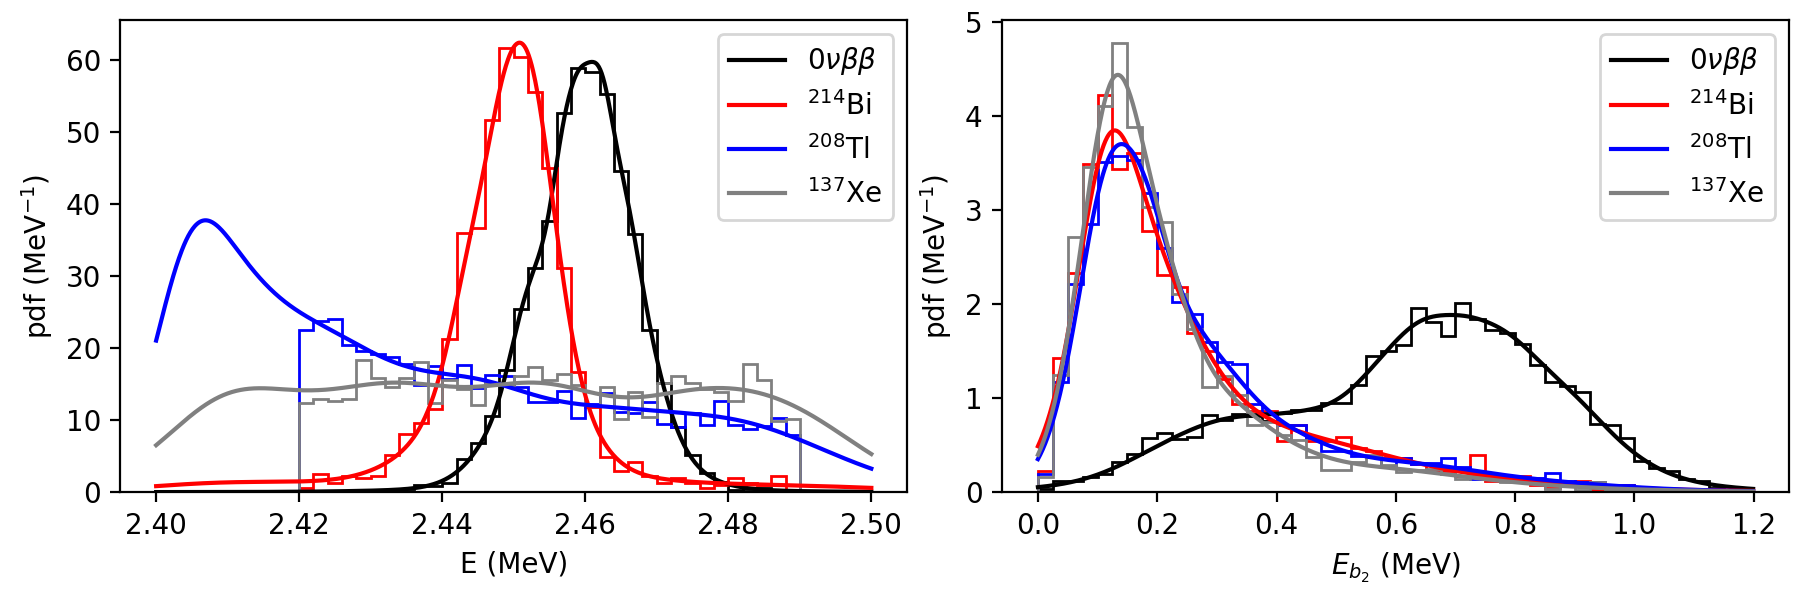

In [7]:
plt.figure(figsize=[9, 3])

plt.subplot(121)
bins = np.arange(2.42, 2.49, 0.002)
E = np.arange(2.4, 2.5, 0.0001)

plt.plot(E, pdf_energy_bb.pdf(E), color=   "k", label=r"$0\nu\beta\beta$")
plt.hist(tracks_0nubb.energy.values, color=   "k", alpha=1, density=True, bins=bins, histtype="step")

plt.plot(E, pdf_energy_Bi.pdf(E), color=   "r", label=r"$^{214}$Bi")
plt.hist(tracks_214Bi.energy.values, color=   "r", alpha=1, density=True, bins=bins, histtype="step")

plt.plot(E, pdf_energy_Tl.pdf(E), color=   "b", label=r"$^{208}$Tl")
plt.hist(tracks_208Tl.energy.values, color=   "b", alpha=1, density=True, bins=bins, histtype="step")

plt.plot(E, pdf_energy_Xe.pdf(E), color="grey", label=r"$^{137}$Xe")
plt.hist(tracks_137Xe.energy.values, color="grey", alpha=1, density=True, bins=bins, histtype="step")

plt.xlabel("E (MeV)")
plt.ylabel(r"pdf (MeV$^{-1}$)")
plt.legend()


plt.subplot(122)
bins = np.arange(0, 1.20, 0.025)
E = np.arange(0, 1.20, 0.001)

plt.plot(E, pdf_eblob2_bb.pdf(E), color=   "k", label=r"$0\nu\beta\beta$")
plt.hist(tracks_0nubb.eblob2.values, color=   "k", alpha=1, density=True, bins=bins, histtype="step")

plt.plot(E, pdf_eblob2_Bi.pdf(E), color=   "r", label=r"$^{214}$Bi")
plt.hist(tracks_214Bi.eblob2.values, color=   "r", alpha=1, density=True, bins=bins, histtype="step")

plt.plot(E, pdf_eblob2_Tl.pdf(E), color=   "b", label=r"$^{208}$Tl")
plt.hist(tracks_208Tl.eblob2.values, color=   "b", alpha=1, density=True, bins=bins, histtype="step")

plt.plot(E, pdf_eblob2_Xe.pdf(E), color="grey", label=r"$^{137}$Xe")
plt.hist(tracks_137Xe.eblob2.values, color="grey", alpha=1, density=True, bins=bins, histtype="step")

plt.xlabel(r"$E_{b_2}$ (MeV)")
plt.ylabel(r"pdf (MeV$^{-1}$)")
plt.legend()

plt.tight_layout(pad=0.4, w_pad=0.05, h_pad=0.1)

<IPython.core.display.Javascript object>


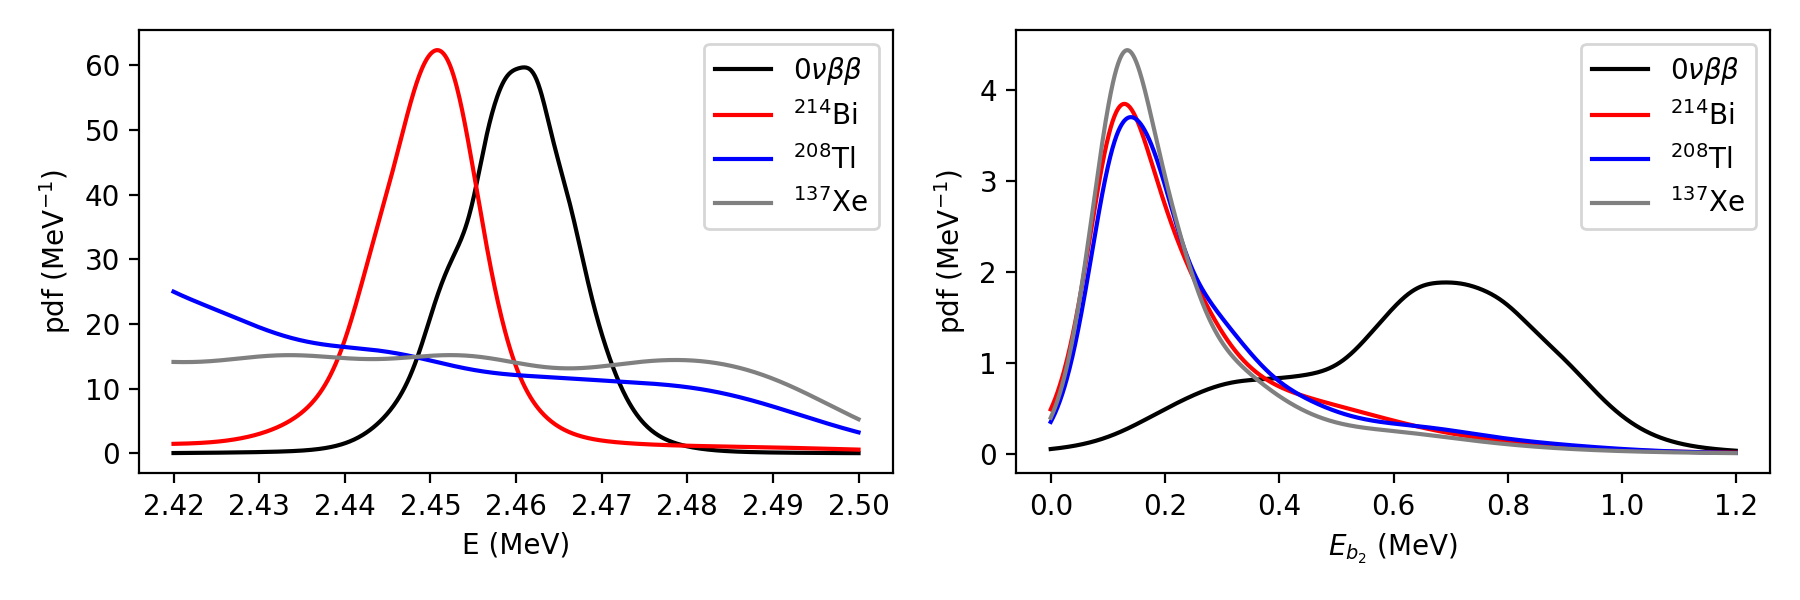

In [8]:
plt.figure(figsize=[9, 3])

plt.subplot(121)
bins = np.arange(2.42, 2.5, 0.002)
E = np.arange(2.42, 2.5, 0.0001)

plt.plot(E, pdf_energy_bb.pdf(E), color=   "k", label=r"$0\nu\beta\beta$")
#plt.hist(tracks_0nubb.energy.values, color=   "k", alpha=0.5, density=True, bins=bins)

plt.plot(E, pdf_energy_Bi.pdf(E), color=   "r", label=r"$^{214}$Bi")
#plt.hist(tracks_214Bi.energy.values, color=   "r", alpha=0.5, density=True, bins=bins)

plt.plot(E, pdf_energy_Tl.pdf(E), color=   "b", label=r"$^{208}$Tl")
#plt.hist(tracks_208Tl.energy.values, color=   "b", alpha=0.5, density=True, bins=bins)

plt.plot(E, pdf_energy_Xe.pdf(E), color="grey", label=r"$^{137}$Xe")
#plt.hist(tracks_137Xe.energy.values, color="grey", alpha=0.5, density=True, bins=bins)

plt.xlabel("E (MeV)")
plt.ylabel(r"pdf (MeV$^{-1}$)")
plt.legend()


plt.subplot(122)
bins = np.arange(0, 1.20, 0.025)
E = np.arange(0, 1.20, 0.001)

plt.plot(E, pdf_eblob2_bb.pdf(E), color=   "k", label=r"$0\nu\beta\beta$")
#plt.hist(tracks_0nubb.eblob2.values, color=   "k", alpha=0.5, density=True, bins=bins)

plt.plot(E, pdf_eblob2_Bi.pdf(E), color=   "r", label=r"$^{214}$Bi")
#plt.hist(tracks_214Bi.eblob2.values, color=   "r", alpha=0.5, density=True, bins=bins)

plt.plot(E, pdf_eblob2_Tl.pdf(E), color=   "b", label=r"$^{208}$Tl")
#plt.hist(tracks_208Tl.eblob2.values, color=   "b", alpha=0.5, density=True, bins=bins)

plt.plot(E, pdf_eblob2_Xe.pdf(E), color="grey", label=r"$^{137}$Xe")
#plt.hist(tracks_137Xe.eblob2.values, color="grey", alpha=0.5, density=True, bins=bins)

plt.xlabel(r"$E_{b_2}$ (MeV)")
plt.ylabel(r"pdf (MeV$^{-1}$)")
plt.legend()

plt.tight_layout()

## Efficiencies

In [9]:
# efficiencies
eff_df = pd.read_csv("../efficiencies_2.4_2.5_MeV.csv").set_index(["Isotope", "G4Volume"])
# eff_df.drop(index="muons", level=0, inplace=True)

# 0nubb
eff_df.loc[("0nubb", "ACTIVE"), "nanalysis"] = tracks_0nubb.index.nunique()

# 137Xe
eff_df.loc[("137Xe", "ACTIVE"), "nanalysis"] = tracks_137Xe.index.nunique()

# 214Bi
vals = tracks_214Bi.G4Volume.value_counts().rename("nanalysis").to_frame()
vals.index.rename("G4Volume", inplace=True)
vals["Isotope"] = "214Bi"
vals = vals.reset_index().set_index(["Isotope", "G4Volume"])
eff_df.loc[("214Bi", slice(None)), "nanalysis"] = vals

# 208Tl
vals = tracks_208Tl.G4Volume.value_counts().rename("nanalysis").to_frame()
vals.index.rename("G4Volume", inplace=True)
vals["Isotope"] = "208Tl"
vals = vals.reset_index().set_index(["Isotope", "G4Volume"])
eff_df.loc[("208Tl", slice(None)), "nanalysis"] = vals

In [10]:
# 0nubb
sel = tracks_0nubb.energy.between(Emin, Emax)
eff_df.loc[("0nubb", "ACTIVE"), "npdf"] = sel.sum()

# 137Xe
sel = tracks_137Xe.energy.between(Emin, Emax)
eff_df.loc[("137Xe", "ACTIVE"), "npdf"] = sel.sum()

# 214Bi
vals = tracks_214Bi[tracks_214Bi.energy.between(Emin, Emax)].G4Volume.value_counts().rename("npdf").to_frame()
vals.index.rename("G4Volume", inplace=True)
vals["Isotope"] = "214Bi"
vals = vals.reset_index().set_index(["Isotope", "G4Volume"])
eff_df.loc[("214Bi", slice(None)), "npdf"] = vals

# 208Tl
vals = tracks_208Tl[tracks_208Tl.energy.between(Emin, Emax)].G4Volume.value_counts().rename("npdf").to_frame()
vals.index.rename("G4Volume", inplace=True)
vals["Isotope"] = "208Tl"
vals = vals.reset_index().set_index(["Isotope", "G4Volume"])
eff_df.loc[("208Tl", slice(None)), "npdf"] = vals

eff_df.fillna(0, inplace=True)

## Save pdf data

In [11]:
filename = "pdfs_2.4_2.5_MeV.h5"

with tb.open_file(filename, mode="w", title="pdfs") as hdf:
    
    # groups
    energy = hdf.create_group("/",       "energy", "energy")
    eblob2 = hdf.create_group("/",       "eblob2", "eblob2")
    
    # save energies
    hdf.create_array(energy, "0nubb", tracks_0nubb.energy.values, "0nubb")
    hdf.create_array(energy, "214Bi", tracks_214Bi.energy.values, "214Bi")
    hdf.create_array(energy, "208Tl", tracks_208Tl.energy.values, "208Tl")
    hdf.create_array(energy, "137Xe", tracks_137Xe.energy.values, "137Xe")
    
    # save eblob2
    hdf.create_array(eblob2, "0nubb", tracks_0nubb.eblob2.values, "0nubb")
    hdf.create_array(eblob2, "214Bi", tracks_214Bi.eblob2.values, "214Bi")
    hdf.create_array(eblob2, "208Tl", tracks_208Tl.eblob2.values, "208Tl")
    hdf.create_array(eblob2, "137Xe", tracks_137Xe.eblob2.values, "137Xe")

eff_df.to_hdf(filename, "efficiencies")

/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '0nubb'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '214Bi'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '208Tl'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use n